I will be making use of transfer learning to help you to create a model to analyse tweet sentiment.
The idea behind transfer learning is that neural networks learn information that generalises to new
problems, particularly the early layer of the network.In computer vision, for example, we can take a model that was
trained on the ImageNet dataset to recognise different features of images such as circles,
then apply that to a smaller dataset and fine-tune the model to be more suited to a specific
task (e.g. classifying images as cats or dogs). This technique allows us to train neural
networks much faster and with far less data than we would otherwise need.
In 2008, Howard and Ruder (2018) introduce a transfer technique for NLP called 'Universal Language
Fine-Tuning'. The approach is as follows

* Train a language model to predict the next word in a sentence. This step is already done. With fastai we
can dowload a model that has been pre-trained for this task on millions of Wikipedia articles. A good language
model already knows a lot about how language works in general. For instance, given the sentence 'Quito
es the capital of', the model might predict 'Ecuador' as the next word. In this case, the model
understands that Quito is closely related to Japan and that 'capital' refers to 'city' here instead
of 'upper-case letter' or 'money'.
* Fine-tune the language model to a more specific task.
The pre-trained language model is good at understanding Wikipedia English, but Twitter English is a
 bit different. We can take the information the Wikipedia model has learned and apply that to a
 Twitter dataset to get a Twitter language model that is good at predicting the next word in a tweet.
* Fine-tune a classification model to identify sentiment using the pre-trained language model.
The idea here is that since our language model already knows a lot about Twitter English,
it's not a huge leap from there to train a classifier that understands that 'love' refers to positive
sentiment and 'hate' refers to negative sentiment. If we tried to train a classifier without using a
pre-trained model it would have to learn the whole language from scratch first, which would be very
difficult and time consuming.

## Loading data

In [5]:
from fastai.text.all import *

In [6]:
vax_tweets = pd.read_csv('../data/vaccination_all_tweets_update04032021.csv')
vax_tweets.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radio Network. Weeknights 7 Pacific-10 Eastern - Email comments/ideas to charles@charlesadlertonight.ca",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


I could use the text column of this dataset to train a Twitter language model,
but since our end goal is sentiment analysis we will need to find another dataset that also contains
sentiment labels to train our classifier. Let's use 'Complete Tweet Sentiment Extraction Data',
which contains 40,000 tweets labelled as either negative, neutral or positive sentiment.

In [7]:
tweets = pd.read_csv('../data/training sentiment model/tweet_dataset.csv')
tweets.head()

,textID,sentiment,author,text,old_text,aux_id,new_sentiment,selected_text
0,1956967341,empty,xoshayzers,i know i was listenin to bad habit earlier and i started freakin at his part =[,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,p1000000000,NaN,NaN
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,Layin n bed with a headache ughhhh...waitin on your call...,c811396dc2,negative,headache
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,9063631ab1,negative,gloomy
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends SOON!,2a815f151d,positive,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,"We want to trade with someone who has Houston tickets, but no one will.","@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",82565a56d3,neutral,"We want to trade with someone who has Houston tickets, but no one will."


In [8]:
# Code via https://www.kaggle.com/garyongguanjie/comments-analysis
def de_emojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

# Code via https://www.kaggle.com/pawanbhandarkar/generate-smarter-word-clouds-with-log-likelihood
def tweet_proc(df, text_col='text'):
    df['orig_text'] = df[text_col]
    # Remove twitter handles
    df[text_col] = df[text_col].apply(lambda x:re.sub('@[^\s]+','',x))
    # Remove URLs
    df[text_col] = df[text_col].apply(lambda x:re.sub(r"http\S+", "", x))
    # Remove emojis
    df[text_col] = df[text_col].apply(de_emojify)
    # Remove hashtags
    df[text_col] = df[text_col].apply(lambda x:re.sub(r'\B#\S+','',x))
    return df[df[text_col]!='']

In [9]:
# clean text data and combine the two dataframes
tweets = tweets[['old_text', 'new_sentiment']].rename(columns={'old_text':'text', 'new_sentiment':'sentiment'})
vax_tweets['sentiment'] = np.nan

tweets = tweet_proc(tweets)
vax_tweets = tweet_proc(vax_tweets)

In [11]:
df_lm = tweets[['text', 'sentiment']].append(vax_tweets[['text', 'sentiment']])
df_clas = df_lm.dropna(subset=['sentiment'])
print('Rows for Language Model: ', df_lm))
print('Rows for Classification Model: ', len(df_clas))

Rows in all dataset:  84832
Rows in training dataset:  31323


In [12]:
df_clas.head()

,text,sentiment
1,Layin n bed with a headache ughhhh...waitin on your call...,negative
2,Funeral ceremony...gloomy friday...,negative
3,wants to hang out with friends SOON!,positive
4,"We want to trade with someone who has Houston tickets, but no one will.",neutral
5,Re-pinging why didn't you go to prom? BC my bf didn't like my friends,negative


## Training a Language Model

To train our language model I can use self-supervised learning; I just need to give the model
some text as an independent variable and fastai will automatically preprocess it and create a
dependent variable for us. I can do this in one line of code using the DataLoaders class,
which converts our input data into a DataLoader object that can be used as an input to a fastai Learner.

In [13]:
dls_lm = TextDataLoaders.from_df(df_lm, text_col='text', is_lm=True, valid_pct=0.1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


C:\Users\marce\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Here I told fastai that I am working with text data, which is contained in the text column
of a pandas DataFrame called df_lm. I set is_lm=True since we want to train a language model, so
fastai needs to label the input data for us. Finally, I told fastai to hold out a random 10% of our
data for a validation set using valid_pct=0.1

Let's take a look at the first two rows of the DataLoader using show_batch

In [15]:
dls_lm.show_batch(max_n=2)

,text,text_
0,xxbos i received my 1st dose of the this morning . xxbos xxmaj sputnik v is one of the candidates used for the xxmaj mutual xxmaj cooperation xxmaj vaccination xxmaj program in xxbos xxmaj feel privileged to have received my first dose of the xxup covid-19 vaccination at the very efficient xxbos xxmaj in xxmaj dec 2020 xxup usa xxmaj bought 200 m doses - manufacturing began during clinical trials to expedite,i received my 1st dose of the this morning . xxbos xxmaj sputnik v is one of the candidates used for the xxmaj mutual xxmaj cooperation xxmaj vaccination xxmaj program in xxbos xxmaj feel privileged to have received my first dose of the xxup covid-19 vaccination at the very efficient xxbos xxmaj in xxmaj dec 2020 xxup usa xxmaj bought 200 m doses - manufacturing began during clinical trials to expedite traditional
1,"sorry my bad . xxbos hmm … ok , well i hope you feel better soon babe xxmaj i m a go to bed , i have a long day tomorrow xxbos and now its raining xxbos where is my xxunk belly when i need her ? xxbos d xxup like \n 2021 xxmaj top 8 xxmaj vacinas \n xxmaj brazil xxup sfe xxmaj company \n\n▁ xxup inc \n\n▁ xxup se xxbos","my bad . xxbos hmm … ok , well i hope you feel better soon babe xxmaj i m a go to bed , i have a long day tomorrow xxbos and now its raining xxbos where is my xxunk belly when i need her ? xxbos d xxup like \n 2021 xxmaj top 8 xxmaj vacinas \n xxmaj brazil xxup sfe xxmaj company \n\n▁ xxup inc \n\n▁ xxup se xxbos xxmaj"


We have a new column, text_, which is text offset by one. This is the dependent variable fastai
created for us. By default fastai uses word tokenization, which splits the text on spaces and
punctuation marks and breaks up words like can't into two separate tokens. fastai also has some
special tokens starting with 'xx' that are designed to make things easier for the model;
for example xxmaj indicates that the next word begins with a capital letter and xxunk represents an
unknown word that doesn't appear in the vocabulary very often. You could experiment with subword
tokenization instead, which will split the text on commonly occuring groups of letters instead of
spaces. This might help if you wanted to leave hashtags in since they often contain multiple words
joined together with no spaces, e.g. #CovidVaccine.

## Fine-tuning the language model
Here I passed language_model_learner our DataLoaders, dls_lm, and the pre-trained RNN model,
AWD_LSTM, which is built into fastai. drop_mult is a multiplier applied to all dropouts in the
AWD_LSTM model to reduce overfitting. For example, by default fastai's AWD_LSTM applies
EmbeddingDropout with 10% probability (at the time of writing), but I told fastai that we
want to reduce that to 3%. The metrics we want to track are perplexity, which is the exponential
of the loss (in this case cross entropy loss), and accuracy, which tells us how often our model
predicts the next word correctly. We can also train with fp16 to use less memory and speed up the
training process.

In [16]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()]).to_fp16()

C:\Users\marce\Anaconda3\lib\site-packages\torch\cuda\amp\autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


C:\Users\marce\Anaconda3\lib\site-packages\torch\cuda\amp\grad_scaler.py:116: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.03981071710586548)

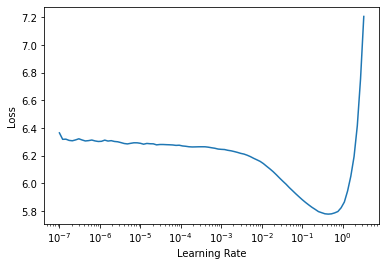

In [17]:
learn.lr_find()